written by Charlie Moffett, NYU CUSP, 2017

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import geopandas as gpd
import pylab as pl
%pylab inline

import os
import statsmodels.api as sm
import statsmodels.formula.api as smf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

Populating the interactive namespace from numpy and matplotlib


__An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easily observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.__

## So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

In [2]:
# The next line will download the 'Energy-and-Water-Data-Disclosure-for-Local-Law-84' data locally
# !wget https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv

In [3]:
# Looking in PUIDATA to show that the file is not there yet
# !ls $PUIDATA

In [4]:
# Moving the dataset 'rows.csv', which is the 'Energy-and-Water-Data-Disclosure-for-Local-Law-84',
# into PUIDATA
# os.system("mv %s %s"%("rows.csv", os.getenv("PUIDATA")))

In [5]:
# creating a pandas dataframe from the dataset
nrg=pd.read_csv(os.getenv("PUIDATA")+'/rows.csv')
nrg.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# However this dataset does not have the number of units. We can find that in the Pluto dataset.
# !wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip

In [7]:
# !unzip -d $PUIDATA mn_mappluto_16v2.zip

In [8]:
# os.system("mv %s %s"%("mn_mappluto_16v2.zip", os.getenv("PUIDATA")))

In [9]:
!ls $PUIDATA

201401-citibike-tripdata.csv
201401-citibike-tripdata.zip
201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201502-citibike-tripdata.csv
201502-citibike-tripdata.zip
201503-citibike-tripdata.csv
201503-citibike-tripdata.zip
201504-citibike-tripdata.csv
201504-citibike-tripdata.zip
201505-citibike-tripdata.csv
201505-citibike-tripdata.zip
201506-citibike-tripdata.csv
201506-citibike-tripdata.zip
201507-citibike-tripdata.csv
201507-citibike-tripdata.zip
201508-citibike-tripdata.csv
201508-citibike-tripdata.zip
201601-citibike-tripdata.csv
201601-citibike-tripdata.zip
201602-citibike-tripdata.csv
201602-citibike-tripdata.zip
201603-citibike-tripdata.csv
201603-citibike-tripdata.zip
201604-citibike-tripdata.csv
201604-citibike-tripdata.zip
201606-citibike-tripdata.csv
201606-citibike-tripdata.zip
201607-citibike-tripdata.csv
201607-citibike-tripdata.zip
201608-citibike-tripdata.csv
201608-citibike-tripdata.zip
201610-citibike-tripdata.csv
201610-citibike-tripdata.zip
201612-citibik

In [10]:
# Confirms that the unzipped CSV is in PUIDATA, otherwise will download it for you
PUIdata=os.getenv("PUIDATA")
if not os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
    print('Downloading...')
    os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip')
    os.system('mv nyc_pluto_16v2%20.zip ' + PUIdata)
    os.system('unzip ' + PUIdata + '/nyc_pluto_16v2%20.zip -d ' + PUIdata)
    if os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
        print('File in place, proceed!')
else:
    print('Go forth')

Go forth


In [11]:
# Reading in the Pluto data for manhattan, which will give me the number of units ber building Manhattan/MNMapPLUTO.shp
bsize=pd.read_csv(PUIdata + "/BORO_zip_files_csv/MN.csv")

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.0,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
1,MN,1,101,101,1.0,1001.0,2.0,1.0,10004.0,E007,...,190636.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
2,MN,1,201,101,1.0,1000.0,2.0,1.0,10004.0,E007,...,193648.0,12b,NaN,199 999,10101.0,NaN,0.0,NaN,1,16V2
3,MN,1,301,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,199 999,10101.0,NaN,0.0,NaN,4,16V2
4,MN,1,401,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,1 99 999,10101.0,NaN,0.0,NaN,4,16V2


In [13]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [14]:
bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistrict', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoo

In [15]:
# Clean up nrg data by throwing away columns I do not need
nrg_new=nrg.drop(['Record Number', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough',
       'DOF Benchmarking Submission Status',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Primary Property Type - Self Selected',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],axis=1)

In [16]:
nrg_new.head()

,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
0,1.000410e+09,NaN,NaN,918919,NaN,NaN
1,4.021460e+09,11375.0,NaN,NaN,82730.0,1.0
2,2.027620e+09,NaN,NaN,64200,NaN,NaN
3,1.006700e+09,10001.0,NaN,NaN,440360.0,1.0
4,2.048300e+09,NaN,NaN,50000,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee617b3860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fee60faada0>]], dtype=object)

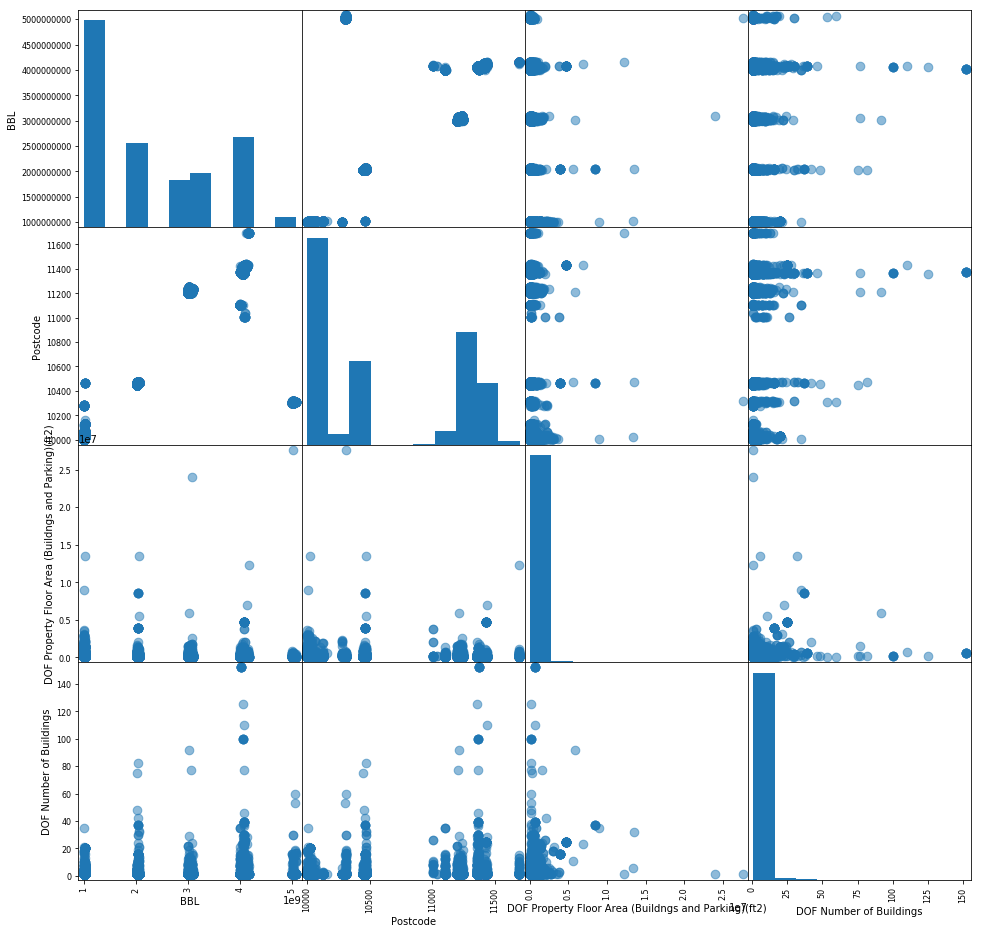

In [17]:
# Make a scatter plot of nrg_new
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg_new, s=300, figsize=(16, 16))

Figure 1: scatter matrix of all numerical values in the files

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's). But most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column), so Pandas refuses to plot them - it doesn't know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

In [18]:
# Transforms values to float (when possible)
nrg_new['Site EUI(kBtu/ft2)']=pd.to_numeric(nrg_new['Site EUI(kBtu/ft2)'],errors='coerce')

In [19]:
nrg_new['BBL']=pd.to_numeric(nrg_new['BBL'],errors='coerce')

In [20]:
nrg_new['Reported Property Floor Area (Building(s)) (ft²)']=pd.to_numeric(
    nrg_new['Reported Property Floor Area (Building(s)) (ft²)'],errors='coerce')

In [21]:
#How many missing values?
indx = np.isnan(nrg_new['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 4623


In [22]:
#How many missing values?
indx = np.isnan(nrg_new['Reported Property Floor Area (Building(s)) (ft²)']).sum()
print("Invalid entries changed to NaN: {}".format(indx))
#do it for however many columns you need

Invalid entries changed to NaN: 3125


In [23]:
##check that your conversion worked:
print(nrg_new['Site EUI(kBtu/ft2)'].dtype)

float64


In [24]:
bsize.BBL.dtype

dtype('float64')

In [25]:
# Clean up PLUTO data
bsize_new=bsize.drop(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistrict', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
       'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
       'Version'],axis=1)

In [26]:
bsize_new.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL
0,0,0,1900,1.000010e+09
1,0,0,1900,1.000010e+09
2,0,0,1900,1.000010e+09
3,0,0,0,1.000010e+09
4,0,0,0,1.000010e+09


# MERGE THE DATASETS

In [27]:
# Look at the syntax for pandas.merge
# pd.merge?

In [28]:
(bsize_new.BBL.values[0]), (nrg_new.BBL.values[0])

(1000010010.0, 1000410001.0)

In [29]:
mergedata=nrg_new.merge(bsize_new,on='BBL')

In [30]:
mergedata.dropna
mergedata.shape

(6536, 9)

In [31]:
mergedata.head()

,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,10001.0,NaN,NaN,440360.0,1.0,0,1,1987
1,1.004370e+09,10009.0,NaN,NaN,52390.0,1.0,0,4,1920
2,1.013110e+09,10022.0,125.4,330000.0,313200.0,1.0,0,56,1977
3,1.009220e+09,10003.0,NaN,NaN,98260.0,1.0,148,148,1963
4,1.007400e+09,NaN,NaN,68329.0,NaN,NaN,0,1,1920


In [32]:
mergedata=mergedata.drop(['Postcode','DOF Number of Buildings'],axis=1)

mergedata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360.0,0,1,1987
1,1.004370e+09,NaN,NaN,52390.0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977
3,1.009220e+09,NaN,NaN,98260.0,148,148,1963
4,1.007400e+09,NaN,68329.0,NaN,0,1,1920


In [33]:
mergedata.columns=['BBL','SiteEUI','AreaReported','DOFfloorArea','UnitsRes','UnitsTotal','YearBuilt']
mergedata.head()

,BBL,SiteEUI,AreaReported,DOFfloorArea,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360.0,0,1,1987
1,1.004370e+09,NaN,NaN,52390.0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977
3,1.009220e+09,NaN,NaN,98260.0,148,148,1963
4,1.007400e+09,NaN,68329.0,NaN,0,1,1920


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee609fd7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fee5a3214a8>]], dtype=object)

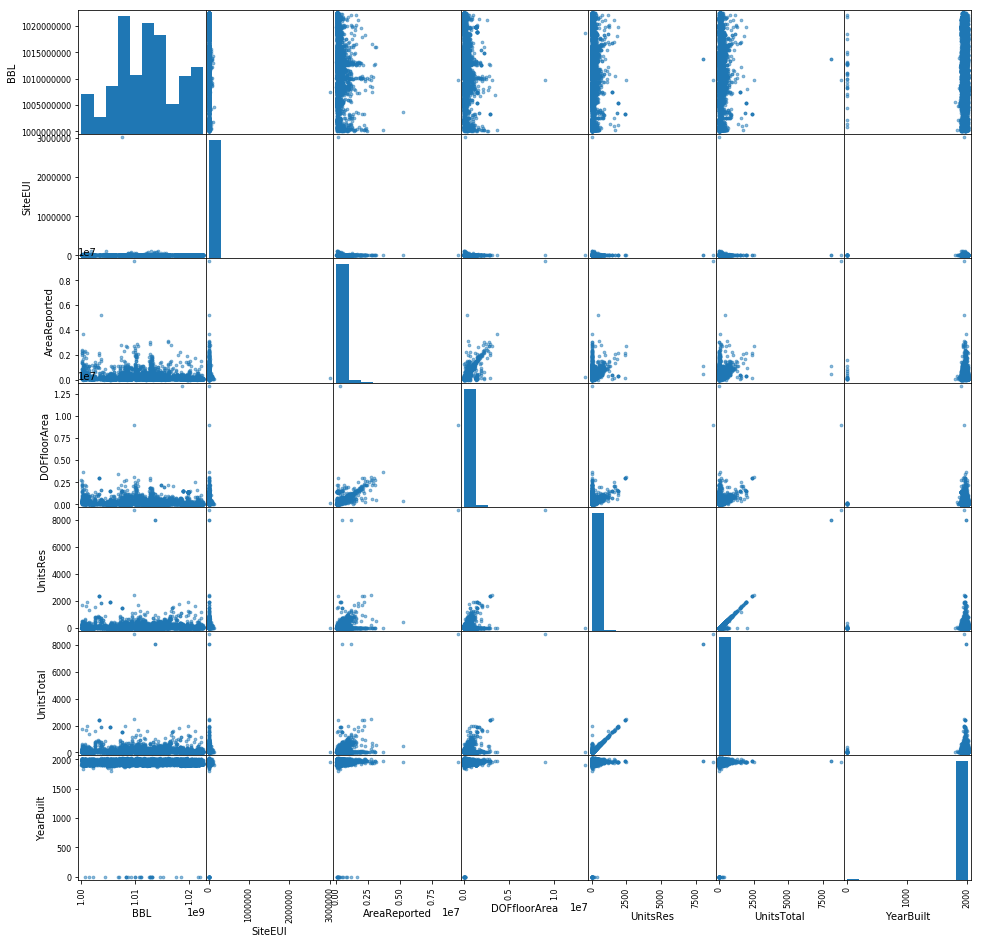

In [34]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (mergedata, s=30, figsize=(16, 16))

Figure 2: scatter matrix of merged dataset

Figure 2 does the same as Figure 1 but because I converted additional columns into float, pandas was able to plot the additional columns. The columns I am interested in are u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. These are the columns previously omitted, but now included. I can see now the correlation between all variables contained in my final dataset.

# Make a scatter plot first of Energy vs Units.

In [35]:
# Convert energy per sq ft into Energy TOTAL
mergedata['EnergyTOTAL']=mergedata.SiteEUI*mergedata.AreaReported

Text(0,0.5,'Number of Units')

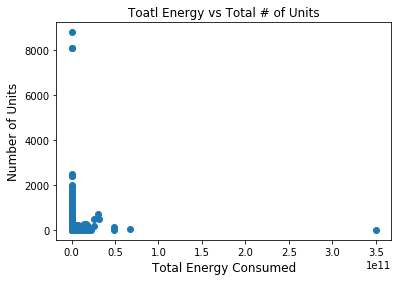

In [36]:
# Now plotting it
pl.scatter(mergedata.EnergyTOTAL,mergedata.UnitsTotal)
pl.title('Toatl Energy vs Total # of Units')
pl.xlabel('Total Energy Consumed',fontsize=12)
pl.ylabel('Number of Units', fontsize=12)

Figure 3: Plots total energy consumption of each BBL vs the number of units in the building

It looks really bad because all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. So we have some outliers with very high numbers of units, and another outlier with a very high amount of total energy consumed (but low total number of units).

I chose Total Units instead of Residential Units because a number of the BBLs don't have any residential units, so in order to plot more points I went the Total Units route.

### Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted

(1, 1000)

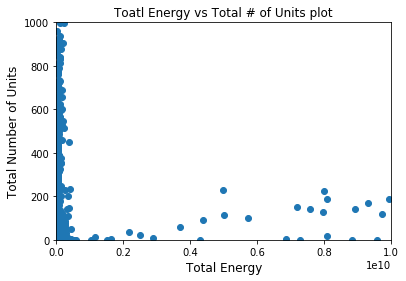

In [37]:
# zoomed in scatter plot
pl.scatter(mergedata.EnergyTOTAL, mergedata.UnitsTotal)
pl.title('Toatl Energy vs Total # of Units plot')
pl.xlabel('Total Energy',fontsize=12)
pl.ylabel('Total Number of Units', fontsize=12)
pl.xlim(1000,1e10)
pl.ylim(1,1000)

Figure 4: same as Figure 3, but zooms into the region where most points are.

I accomplished this zooming in by cutting my x and y axes in the process of plotting them by using xlim=(1000,1e10), ylim=(1,1000).

# Make a log plot

In [38]:
# Remove the data that have nrg==0 by indexing the array
datacut = mergedata[(mergedata.EnergyTOTAL>0) & (mergedata.UnitsTotal>10) & (mergedata.UnitsTotal<1000)]

In [39]:
datacut.dropna()
datacut.head()

,BBL,SiteEUI,AreaReported,DOFfloorArea,UnitsRes,UnitsTotal,YearBuilt,EnergyTOTAL
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977,41382000.0
16,1.008150e+09,117.0,364000.0,364000.0,0,24,1954,42588000.0
18,1.005050e+09,82.1,235370.0,214110.0,0,24,1926,19323877.0
19,1.021420e+09,137.7,64806.0,64816.0,54,62,1924,8923786.2
20,1.021750e+09,103.2,62839.0,62847.0,75,85,1920,6484984.8


(100000.0, 10000000000.0)

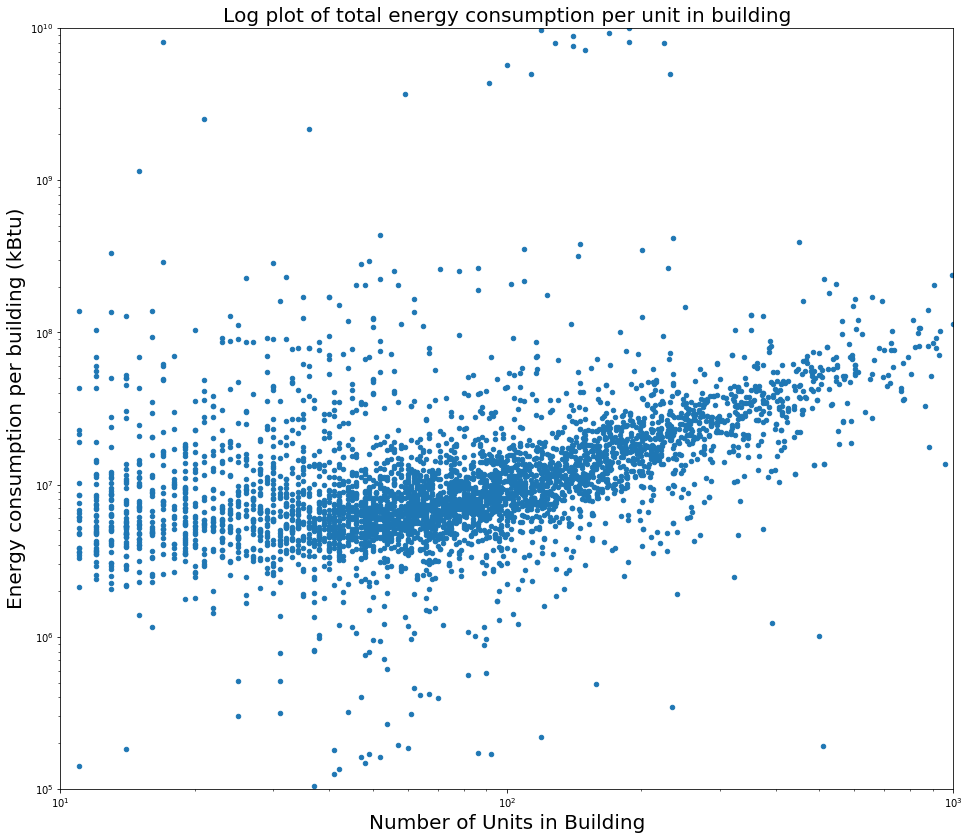

In [40]:
# Plotting the log
ax = datacut.plot(kind='scatter', y='EnergyTOTAL', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title('Log plot of total energy consumption per unit in building',fontsize=20)
ax.set_xlim(10,10e2)
ax.set_ylim(10e4,10e9)

Figure 5: Plots the log of energy consumption per building (kBtu) against the log of the total number of units in the building.

One of the great things about log is that it will compress the high x and high y values, and expand the small x and small y values. When the points in a plot all look scrunched against the axis, the log plot fans these points out. Often we prefer working with log(likelihood) instead of the likelihood itself, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood).

I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. Also I removed the buildings with several thousand units. Points like that at the edge of my range would have a lot of leverage, however they are not spurious entries like the 0, which I believe are missing values, or perhaps abandoned lots. These are good datapoint that I need to throw away functionally for my analysis to work.

# Fit a line through the data

In [41]:
# Using statsmodels to fit a line for TotalUnits Vs TotalEnergyConsumed
x=datacut.UnitsTotal
y=datacut.EnergyTOTAL
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X,missing='drop').fit()
linmodel.summary()
# We see hints of a linear relation in log space, so we want to fit a line to the log of our variables, 
# not the variables themselves

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            EnergyTOTAL   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     846.1
Date:                Sun, 03 Dec 2017   Prob (F-statistic):          8.60e-170
Time:                        18:40:05   Log-Likelihood:                -2570.3
No. Observations:                4251   AIC:                             5145.
Df Residuals:                    4249   BIC:                             5157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0800      0.033    181.537      0.000         6.014     6.146
UnitsTotal     0.5044      0.017     29.087      0.000         0.470     0.538
==============================================================================
Omnibus:                     2284.377   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45410.613
Skew:                           2.123   Prob(JB):                         0.00
Kurtosis:                      18.438   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Choose which is your DEPENDENT and which is your INDEPENDENT variable

Number of units should be the independent variable - we are assuming that total energy consumption depends on the total number of units in the building. 

We'll test both fits anyhow just to be sure.

Text(0.5,1,'Log Plot of # of units vs Energy consumed with fitted line')

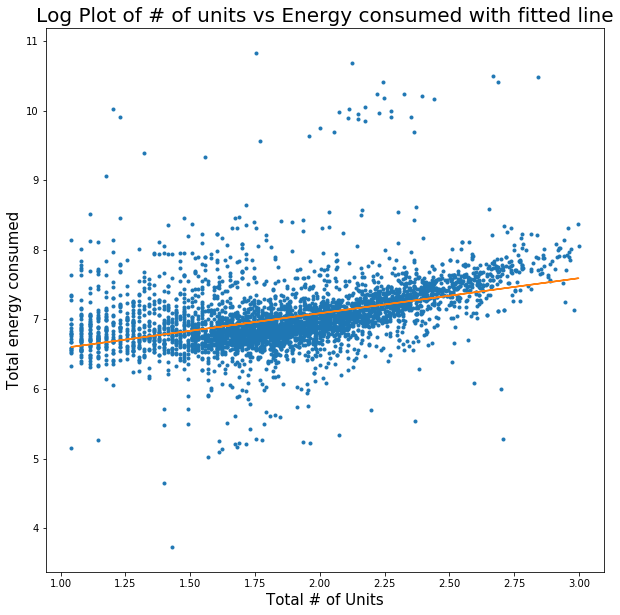

In [42]:
# Fit a line to Units vs Energy
pl.figure(figsize=(10,10))
pl.plot(np.log10(datacut.UnitsTotal),np.log10(datacut.EnergyTOTAL),'.')

pl.plot(np.log10(datacut.UnitsTotal),linmodel.predict())

pl.xlabel('Total # of Units',fontsize=15)
pl.ylabel('Total energy consumed',fontsize=15)
pl.title('Log Plot of # of units vs Energy consumed with fitted line',fontsize=20)

Figure 6: Plots the log of the total # of units (independent variable) against total energy consumed in the building (dependent variable). 

The line seems to make sense - as the number of units in a building increases, the total energy consumption of that building increases. There are a handful of 'outliers' with really high energy consumption compared to their unit count, but nothing crazy and for the most part the points are clustered around the fitted line.

In [43]:
# Using statsmodels to fit a line for Total Energy Consumed Vs Total # of Units
x2=datacut.EnergyTOTAL
y2=datacut.UnitsTotal
X2 = sm.add_constant(np.log10(x2))
linmodel2 = sm.OLS(np.log10(y2), X2,missing='drop').fit()
linmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     846.1
Date:                Sun, 03 Dec 2017   Prob (F-statistic):          8.60e-170
Time:                        18:40:05   Log-Likelihood:                -1663.6
No. Observations:                4251   AIC:                             3331.
Df Residuals:                    4249   BIC:                             3344.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.4245      0.080     -5.319      0.000        -0.581    -0.268
EnergyTOTAL     0.3292      0.011     29.087      0.000         0.307     0.351
==============================================================================
Omnibus:                      126.654   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.940
Skew:                          -0.425   Prob(JB):                     1.11e-30
Kurtosis:                       3.239   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Log Plot of Energy consumed vs number of units with fitted line')

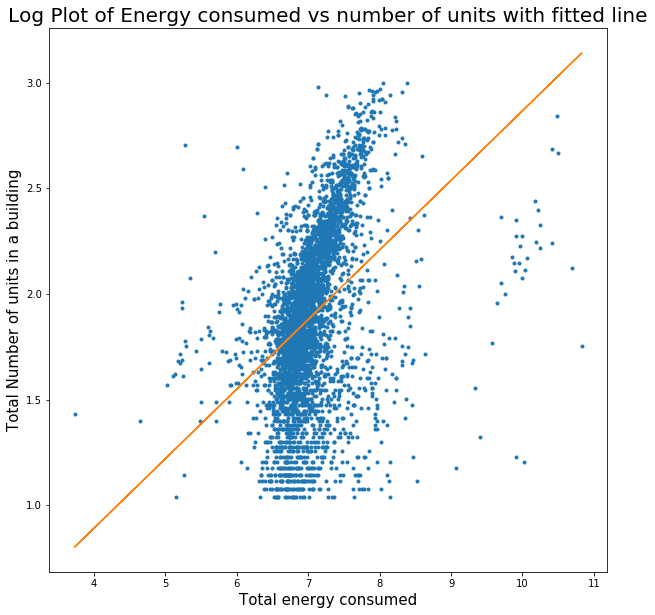

In [44]:
pl.figure(figsize=(10,10))
pl.plot(np.log10(datacut.EnergyTOTAL),np.log10(datacut.UnitsTotal),'.')

pl.plot(np.log10(datacut.EnergyTOTAL),linmodel2.predict(),'-')

pl.xlabel('Total energy consumed',fontsize=15)
pl.ylabel('Total Number of units in a building',fontsize=15)
pl.title('Log Plot of Energy consumed vs number of units with fitted line',fontsize=20)

Figure 7: same as Figure 6 but with the axes flipped - now we plot the log of the total energy consumed (independent variable) against total # of units (dependent variable).

The line doesn't look like a good fit at all. The data doesn't quite make sense either though - we know that the # of units in a building isn't contingent on how much energy it consumes.

# Evaluate which is better by calculating the chi square

In [45]:
# Create function to calculate the chi square
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.sqrt(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((model - data)**2) / errors**2).sum()
    else: 
        print ('''ERROR:must pass arrays of identical dimension for data, model and (optional) error)''')
        return -1

In [46]:
# Errors on measured total # of units quantity
errorsU=chi2(data=datacut.UnitsTotal,model=linmodel2.predict())
errorsU
# Error is square root of observed value for i-th data point

485199.28523513768

In [47]:
# Errors on measured total energy consumed quantity
errorsE=chi2(data=datacut.EnergyTOTAL,model=linmodel.predict())
errorsE

533694261996.76569

In [48]:
# Assume Poisson statistics for the errors on the independent variable. 
# Poisson statistics means uncertainty is the square root of your measurement. 
# Professor Bianco's formula for the errors.
errorsnrg = np.sqrt((datacut['AreaReported'])**2 +\
                (datacut['SiteEUI']**2))

# Assume count statistics in the number of units as well
errorsunits = np.sqrt(datacut.UnitsTotal)

In [49]:
errorsInLogNrg = np.abs(errorsnrg / datacut.EnergyTOTAL / np.log(10))
errorsInLogUnits = np.abs(errorsunits / datacut.UnitsTotal / np.log(10))

datacut['errorsnrg'] = errorsInLogNrg
datacut['errorsunits'] = errorsInLogUnits

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
datacut.head()

,BBL,SiteEUI,AreaReported,DOFfloorArea,UnitsRes,UnitsTotal,YearBuilt,EnergyTOTAL,errorsnrg,errorsunits
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977,41382000.0,0.003463,0.058035
16,1.008150e+09,117.0,364000.0,364000.0,0,24,1954,42588000.0,0.003712,0.088650
18,1.005050e+09,82.1,235370.0,214110.0,0,24,1926,19323877.0,0.005290,0.088650
19,1.021420e+09,137.7,64806.0,64816.0,54,62,1924,8923786.2,0.003154,0.055155
20,1.021750e+09,103.2,62839.0,62847.0,75,85,1920,6484984.8,0.004208,0.047106


__Please explain the functional form used.__

Professor Bianco wrote the above error measurement steps as she did because the error in the reported energy usage  is the product of two measured quantities, each of which will have errors. As a result, she calculated the error in the reported energy use by taking the square root of the building area squared added to the energy consumption (per sq ft) squared to get the error for the reported energy usage of the whole building, not just energy use per square foot, which is how we've been looking at this data in the entirety of this exercise.

# Fit a 2nd degree polynomial

In [51]:
# Creates a new dataframe that stores log of # of units and total energy consumption for each building as x and y, respectively
df = pd.DataFrame({'x': np.log10(datacut.UnitsTotal), 'y': np.log10(datacut.EnergyTOTAL)})
df['x2'] = df.x**2
df.head()

,x,y,x2
2,1.748188,7.616811,3.056161
16,1.380211,7.629287,1.904983
18,1.380211,7.286094,1.904983
19,1.792392,6.950549,3.212668
20,1.929419,6.811909,3.722657


In [52]:
# Creates variables that will allow us to compare the Units vs Energy line fit and the 
# Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test.
linefit = np.arange(np.log10(datacut.UnitsTotal).min(), np.log10(datacut.EnergyTOTAL).max(), 0.01)
polyfit = pd.DataFrame({'x': linefit, 'x2': linefit**2})

In [53]:
# Passing the formula for a parabola, like we did in class
polyfit2=smf.ols(formula='y ~ x + x2',data=df).fit()
polyfit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     614.2
Date:                Sun, 03 Dec 2017   Prob (F-statistic):          5.05e-235
Time:                        18:40:06   Log-Likelihood:                -2416.4
No. Observations:                4251   AIC:                             4839.
Df Residuals:                    4248   BIC:                             4858.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.1126      0.118     68.578      0.000         7.881     8.345
x             -1.7096      0.125    -13.668      0.000        -1.955    -1.464
x2             0.5776      0.032     17.861      0.000         0.514     0.641
==============================================================================
Omnibus:                     2429.800   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59213.595
Skew:                           2.246   Prob(JB):                         0.00
Kurtosis:                      20.724   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(2, 14)

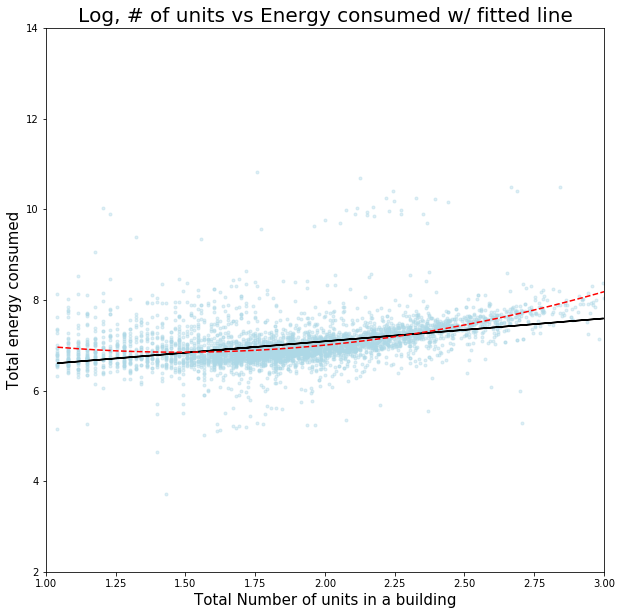

In [54]:
# Plots the 2nd degree polynomial line we just fitted
pl.figure(figsize=(10,10))
pl.plot(np.log10(datacut.UnitsTotal),np.log10(datacut.EnergyTOTAL),'.',color='lightblue',alpha=0.4)

pl.plot(np.log10(datacut.UnitsTotal),linmodel.predict(),color='black')

pl.plot(linefit, polyfit2.predict(sm.add_constant(polyfit)), 'r--')

pl.xlabel('Total Number of units in a building',fontsize=15)
pl.ylabel('Total energy consumed',fontsize=15)
pl.title('Log, # of units vs Energy consumed w/ fitted line',fontsize=20)
pl.xlim(1,3)
pl.ylim(2,14)

Figure 8: Plots the log of the total energy consumed by each building against the log of the total number of units in each building.

We fit a 2nd degree polynomial to this Units vs Energy plot alongside our single degree line from earlier. This new, polynomial (2) fit provides a curved line to describe our data. It accounts for the uptick toward the highest end of # of units in each building, and accordinly appears to be a better model for our final dataset.

## Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test.

In [55]:
print('Log Likelihood Ratio:', -2* (-linmodel.llf - (-polyfit2.llf)))
print('Likelihood ratio from statsmodel', polyfit2.compare_lr_test(linmodel)[0])

Log Likelihood Ratio: -307.810248996
Likelihood ratio from statsmodel 307.810248996


To compare this LR statistic to a chi sq table, we compare the number of degrees of freedom against our alpha value.

If alpha = 0.05, the chi square value for 1 degree of freedom is 3.84. This number is tiny compared to the log likelihood ratio we got! We can say then that Model2 is preferable to Model1, where Model1 is the least complex (fewer parameters). The polynomial model is better than the linear model.

Grade: 10/10